# Desafio 7

## Prever notas de matemática do ENEM 2016

* Importando as bibliotecas necessárias

In [24]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns

* Separando o DataFrame em teste e treino

In [25]:
df_train = pd.read_csv('C:\\Users\\Impieri\\codenation\\enem-2\\train.csv', sep=",", encoding="UTF8" )
df_test = pd.read_csv('C:\\Users\\Impieri\\codenation\\enem-2\\\\test.csv', sep=",", encoding="UTF8" )
df_resposta = pd.DataFrame()

* Verificando se os dataframes de test e treino tem as mesmas colunas

In [26]:
print(set(df_test.columns).issubset(set(df_train.columns)))

True


* Criando o DataFrame de resposta e adicionando as inscrições

In [27]:
df_resposta['NU_INSCRICAO'] = df_test['NU_INSCRICAO']
df_resposta.head()

,NU_INSCRICAO
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968
2,b38a03232f43b11c9d0788abaf060f7366053b6d
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d
4,715494628a50142ce8cb17191cfe6d0f3cae0934


* Selecionar somente valores inteiros e floats

In [28]:
df_test = df_test.select_dtypes(include=['int64', 'float64'])

* colunas que temos para trabalhar

In [29]:
df_test.columns

Index(['CO_UF_RESIDENCIA', 'NU_IDADE', 'TP_COR_RACA', 'TP_NACIONALIDADE',
       'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO',
       'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO',
       'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA',
       'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN',
       'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1',
       'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
       'NU_NOTA_REDACAO'],
      dtype='object')

* verificando as quais Features tem uma maior correlação com o nosso target(NU_NOTA_MT)

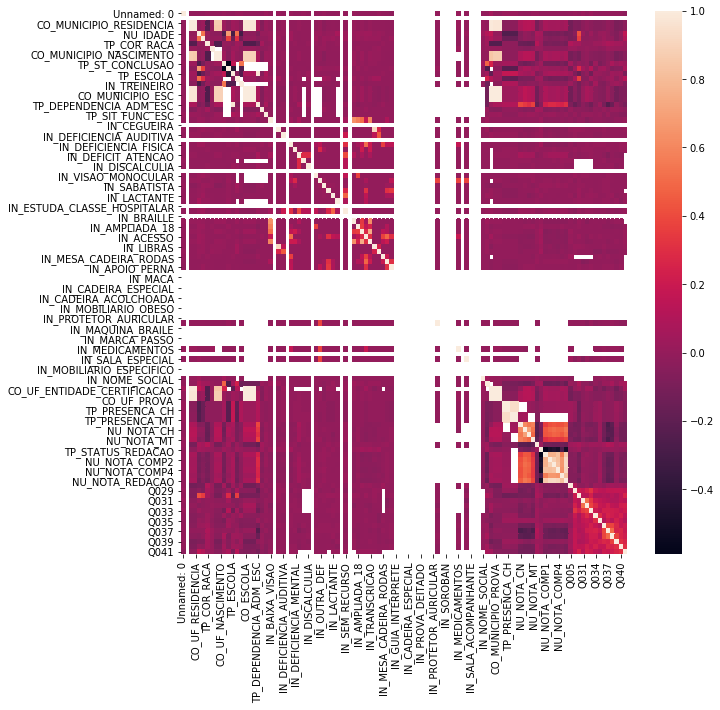

In [31]:
plt.figure(figsize = (10,10))
sns.heatmap(df_train.corr().round(2), annot= False);

* Verificando a correlação das Features utilizadas

In [35]:
var = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 
       'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5' ]
df_test[var].corr()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5
NU_NOTA_CN,1.000000,0.598574,0.545801,0.442692,0.352608,0.390462,0.409225,0.395787,0.395588
NU_NOTA_CH,0.598574,1.000000,0.679993,0.537141,0.434293,0.467964,0.492713,0.485807,0.478836
NU_NOTA_LC,0.545801,0.679993,1.000000,0.495745,0.429795,0.435176,0.447566,0.453682,0.422711
NU_NOTA_REDACAO,0.442692,0.537141,0.495745,1.000000,0.858868,0.918151,0.926185,0.912078,0.810889
NU_NOTA_COMP1,0.352608,0.434293,0.429795,0.858868,1.000000,0.758740,0.755680,0.818071,0.546895
NU_NOTA_COMP2,0.390462,0.467964,0.435176,0.918151,0.758740,1.000000,0.873625,0.810890,0.645249
NU_NOTA_COMP3,0.409225,0.492713,0.447566,0.926185,0.755680,0.873625,1.000000,0.829071,0.660097
NU_NOTA_COMP4,0.395787,0.485807,0.453682,0.912078,0.818071,0.810890,0.829071,1.000000,0.619196
NU_NOTA_COMP5,0.395588,0.478836,0.422711,0.810889,0.546895,0.645249,0.660097,0.619196,1.000000


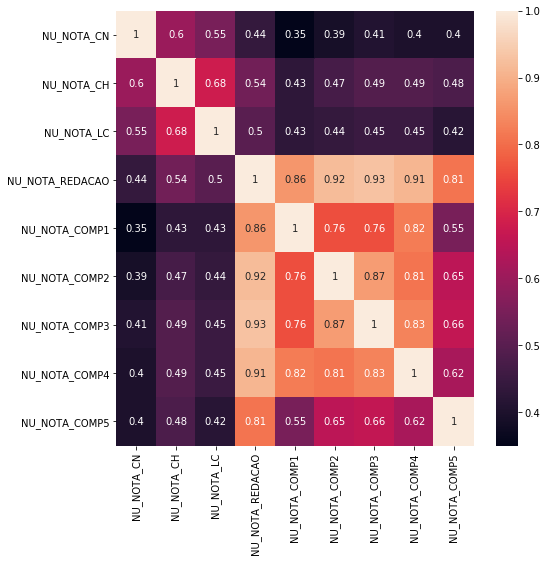

In [37]:
plt.figure(figsize = (8,8))
sns.heatmap(df_test[var].corr().round(2), annot= True);

* Features que serão utilizadas

In [39]:
features = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']

* Retirando os valores nulos

In [40]:
df_train = df_train.loc[
    (df_train['NU_NOTA_CN'].notnull()) & (df_train['NU_NOTA_CH'].notnull()) & (df_train['NU_NOTA_LC'].notnull()) & (
        df_train['NU_NOTA_REDACAO'].notnull()) & (df_train['NU_NOTA_MT'].notnull())]

In [41]:
df_train['NU_NOTA_CN'].fillna(0, inplace=True)
df_train['NU_NOTA_CH'].fillna(0, inplace=True)
df_train['NU_NOTA_REDACAO'].fillna(0, inplace=True)
df_train['NU_NOTA_LC'].fillna(0, inplace=True)
df_test['NU_NOTA_CN'].fillna(0, inplace=True)
df_test['NU_NOTA_CH'].fillna(0, inplace=True)
df_test['NU_NOTA_REDACAO'].fillna(0, inplace=True)
df_test['NU_NOTA_LC'].fillna(0, inplace=True)

* Separando o target (y), x_train e x_test

In [ ]:
y = df_train['NU_NOTA_MT']
x_train = df_train[features]
x_test = df_test[features]

* Usando o StandardScaler para padronizar as bases
* Criando o regressor com RendomForest
* Aplicando a base de treino no regressor para treina-lo

In [44]:
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

regressor = RandomForestRegressor(n_estimators=15)
regressor.fit(X_train, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=15, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

* Usando o regressor para prever as notas da base de teste

In [45]:
pred_notas = regressor.predict(X_test)

* Arredondando as Notas previstas
* Colocando a previsão no DataFrame de resposta
* Salvando o DataFrame em um .csv

In [47]:
df_resposta['NU_NOTA_MT'] = np.around(pred_notas, 2)

df_resposta['NU_NOTA_MT'].unique()

df_resposta.to_csv('answer_1.csv', index=False, header=True)